The dataset provided is the Sentiment140 Dataset which consists of 1,600,000 tweets that have been extracted using the Twitter API. 

https://www.kaggle.com/datasets/kazanova/sentiment140/data


Objective: Classifying the tweets into positive or negative sentiments.

# Importing libraries

In [216]:
# utilities
import re
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Read and Load dataset

In [186]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# EDA

In [187]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [188]:
df.shape

(1600000, 6)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [190]:
df.isnull().any(axis=1).sum()

np.int64(0)

In [191]:
df['target'].unique()

array([0, 4])

In [192]:
df['target'].nunique()

2

Visualisation of target variables

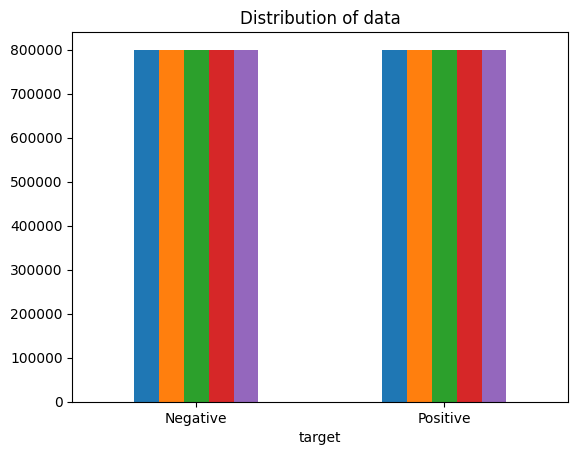

In [193]:
# Plotting the distribution for dataset
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

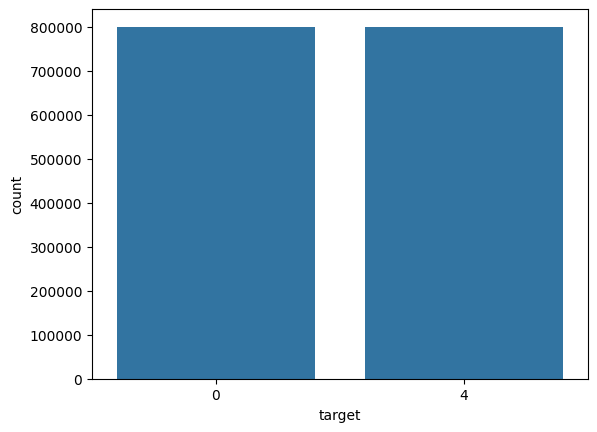

In [194]:
sns.countplot(x='target', data=df)

# Preprocessing

In [195]:
data = df[['text','target']]
data['target'] = data['target'].replace(4,1)
data['target'].unique()

C:\Users\lifro\AppData\Local\Temp\ipykernel_30392\44870659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


array([0, 1])

In [196]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [197]:
# take 20000 examples only
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
dataset = pd.concat([data_pos, data_neg])

In [198]:
# convert text ot loweracse
dataset['text']=dataset['text'].str.lower()
dataset['text'].head()

800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

Generating a list of stopwords

In [199]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [200]:
# Remove stopwords from dataset
STOPWORDS = set(stopwords)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [201]:
# remove punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [202]:
# remove repeated characters
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
dataset['text'] = dataset['text'].apply(lambda x: remove_repeating_char(x))
dataset['text'].head()

800000                   love health4uandpets u guys r best
800001    im meting one besties tonight cant wait girl talk
800002    darealsunisakim thanks twiter ad sunisa got me...
800003    sick realy cheap hurts much eat real fod plus ...
800004                         lovesbroklyn2 efect everyone
Name: text, dtype: object

In [203]:
# remove numbers
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: remove_numbers(x))
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meting one besties tonight cant wait girl talk
800002    darealsunisakim thanks twiter ad sunisa got me...
800003    sick realy cheap hurts much eat real fod plus ...
800004                          lovesbroklyn efect everyone
Name: text, dtype: object

In [204]:
# tokenize text
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [205]:
# stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [206]:
# lemmatize
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [207]:
X = data.text
y = data.target

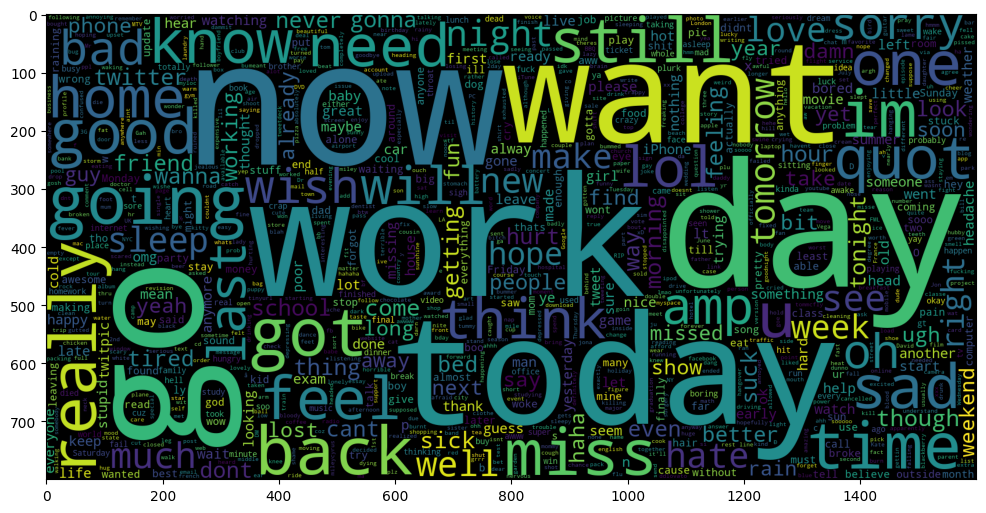

In [208]:
# word cloud
data_neg = data['text'][:800000]
plt.figure(figsize = (12,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# Splitting Train/Test data

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state=123)

# Transform data using TF-IDF

In [211]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [212]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Training Model

In [217]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

## Naive Bayes

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     40009
           1       0.80      0.80      0.80     39991

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



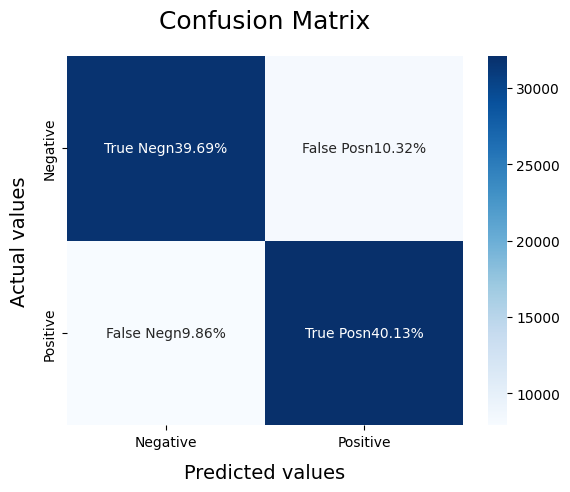

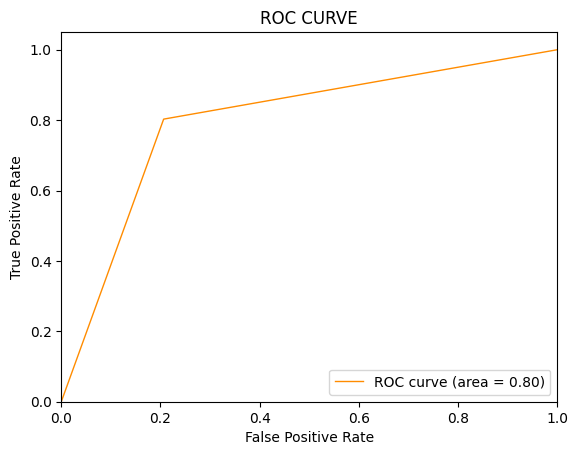

In [219]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## SVC

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40009
           1       0.81      0.82      0.81     39991

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



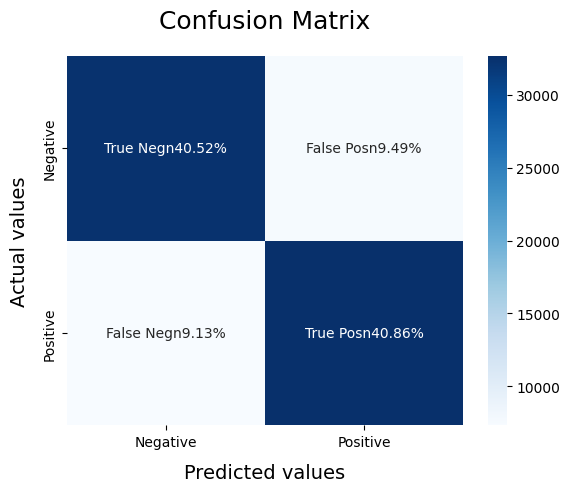

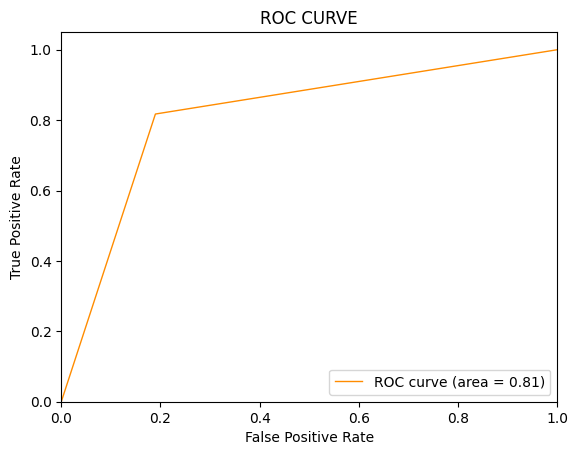

In [220]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40009
           1       0.81      0.83      0.82     39991

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



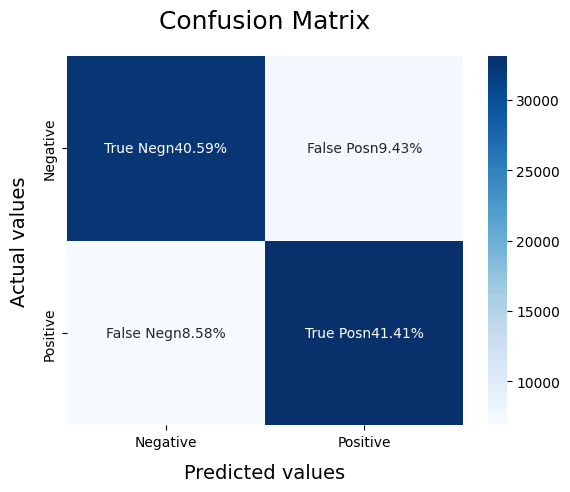

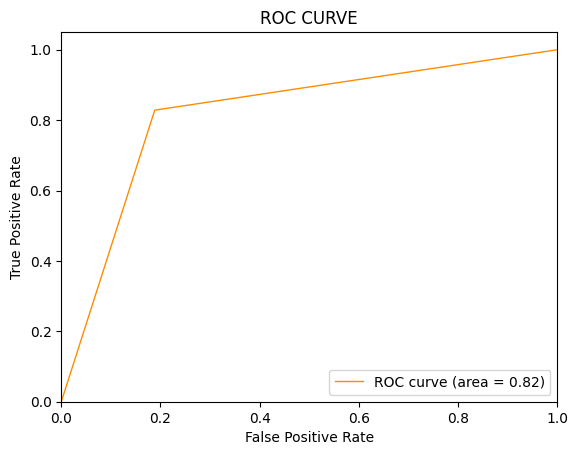

In [221]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)